# Accuracy versus energy
Goals=Compare energy consumed versus learning advancement.

No information on training accuracy, only evaluations.

ToDo:
- compute total energy timeserie
- plot in parallel with accuracy
- compute energy between each eval

In [1]:
import pandas as pd
# import modin.pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
log_dir = f"{logs}/resultats_11-23/"
save_dir = f"{processed_log_dir}/maskrcnn/"
path = f"{log_dir}/maskrcnn/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"

# energy = dd.read_csv(
#     energy_file, 
#     dtype={'cpu': 'object', 'socket': 'object', 'domain': 'object'}).drop(columns=["Unnamed: 0"])
# energy.to_parquet(save_dir+'energy.parquet', engine='pyarrow')
energy = dd.read_parquet(save_dir+'energy.parquet', engine='pyarrow')
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs.job

0     126852
1     126853
2     126854
3     126855
4     126856
5     126857
6     126858
7     126859
8     126860
9     126861
10    126862
11    126863
Name: job, dtype: int64

In [3]:
job = 126861
plot_df = jobs[(jobs["job"]==job)]

In [4]:
file = plot_df.file.values[0]
file.split("/")[-2:]

['126861', '231109235927994393412_1.log']

In [5]:
import sys
sys.path.append("../../logging/mlperf_logging/")
from compliance_checker.mlp_parser import parse_file


log_file = path + "/".join(file.split("/")[-2:])
print(log_file)

loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)
mllog = mllog.drop(['metadata.file', 'metadata.lineno', 'metadata.tensor', 'metadata.status'], axis=1)

/Users/mathildepro/Documents/code_projects/logs/Apollo/resultats_11-23//maskrcnn/126861/231109235927994393412_1.log


In [6]:
mllog[mllog["key"]=="tracked_stats"]

,value,metadata.first_epoch_num,metadata.epoch_count,metadata.epoch_num,value.time,value.data,value.loss,value.loss_classifier,value.loss_box_reg,value.loss_mask,value.loss_objectness,value.loss_rpn_box_reg,value.throughput,metadata.step,value.BBOX,value.SEGM,metadata.throughput,timestamp,key
52,NaN,NaN,NaN,NaN,0.138640,0.008783,2.404536,1.071985,0.040566,0.781683,0.394800,0.115501,692.442934,50.0,NaN,NaN,NaN,1.699571e+12,tracked_stats
54,NaN,NaN,NaN,NaN,0.130263,0.006517,1.831426,0.674442,0.052235,0.712379,0.287885,0.104484,736.969649,100.0,NaN,NaN,NaN,1.699571e+12,tracked_stats
56,NaN,NaN,NaN,NaN,0.129091,0.005840,1.718256,0.616588,0.098079,0.673100,0.232115,0.098375,743.660190,150.0,NaN,NaN,NaN,1.699571e+12,tracked_stats
58,NaN,NaN,NaN,NaN,0.129236,0.005588,1.653008,0.594291,0.124236,0.639000,0.201255,0.094226,742.828593,200.0,NaN,NaN,NaN,1.699571e+12,tracked_stats
60,NaN,NaN,NaN,NaN,0.129466,0.005463,1.598591,0.578140,0.140491,0.607914,0.180645,0.091401,741.505306,250.0,NaN,NaN,NaN,1.699571e+12,tracked_stats
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,NaN,NaN,NaN,NaN,0.141314,0.009459,0.766522,0.257945,0.119829,0.285648,0.046738,0.056362,679.335965,16950.0,NaN,NaN,NaN,1.699573e+12,tracked_stats
822,NaN,NaN,NaN,NaN,0.141297,0.009446,0.766103,0.257749,0.119784,0.285552,0.046678,0.056339,679.421613,17000.0,NaN,NaN,NaN,1.699573e+12,tracked_stats
824,NaN,NaN,NaN,NaN,0.141280,0.009435,0.765629,0.257542,0.119716,0.285444,0.046619,0.056308,679.501748,17050.0,NaN,NaN,NaN,1.699573e+12,tracked_stats
826,NaN,NaN,NaN,NaN,0.141263,0.009423,0.765037,0.257287,0.119631,0.285309,0.046550,0.056261,679.585390,17100.0,NaN,NaN,NaN,1.699573e+12,tracked_stats


In [7]:
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
table = mllog #[mllog["value"].notna()].dropna(axis=1,how='all')
cols = [x for x in table.columns] # if (x != "full_string") and (x != "metadata")]
table[cols][-20:].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,value,metadata.first_epoch_num,metadata.epoch_count,metadata.epoch_num,value.time,value.data,value.loss,value.loss_classifier,value.loss_box_reg,value.loss_mask,value.loss_objectness,value.loss_rpn_box_reg,value.throughput,metadata.step,value.BBOX,value.SEGM,metadata.throughput,timestamp,key
818,nan,nan,nan,nan,0.141329,0.009471,0.767002,0.258148,0.119893,0.285767,0.046802,0.056392,679.267288,16900.000000,nan,nan,nan,1699573372077.000000,tracked_stats
819,679.267288,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1699573372078.000000,throughput
820,nan,nan,nan,nan,0.141314,0.009459,0.766522,0.257945,0.119829,0.285648,0.046738,0.056362,679.335965,16950.000000,nan,nan,nan,1699573378903.000000,tracked_stats
821,679.335965,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1699573378904.000000,throughput
822,nan,nan,nan,nan,0.141297,0.009446,0.766103,0.257749,0.119784,0.285552,0.046678,0.056339,679.421613,17000.000000,nan,nan,nan,1699573385666.000000,tracked_stats
823,679.421613,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1699573385666.000000,throughput
824,nan,nan,nan,nan,0.141280,0.009435,0.765629,0.257542,0.119716,0.285444,0.046619,0.056308,679.501748,17050.000000,nan,nan,nan,1699573392448.000000,tracked_stats
825,679.501748,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1699573392448.000000,throughput
826,nan,nan,nan,nan,0.141263,0.009423,0.765037,0.257287,0.119631,0.285309,0.046550,0.056261,679.585390,17100.000000,nan,nan,nan,1699573399214.000000,tracked_stats
827,679.585390,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1699573399215.000000,throughput


Text(0, 0.5, 'Accuracy')

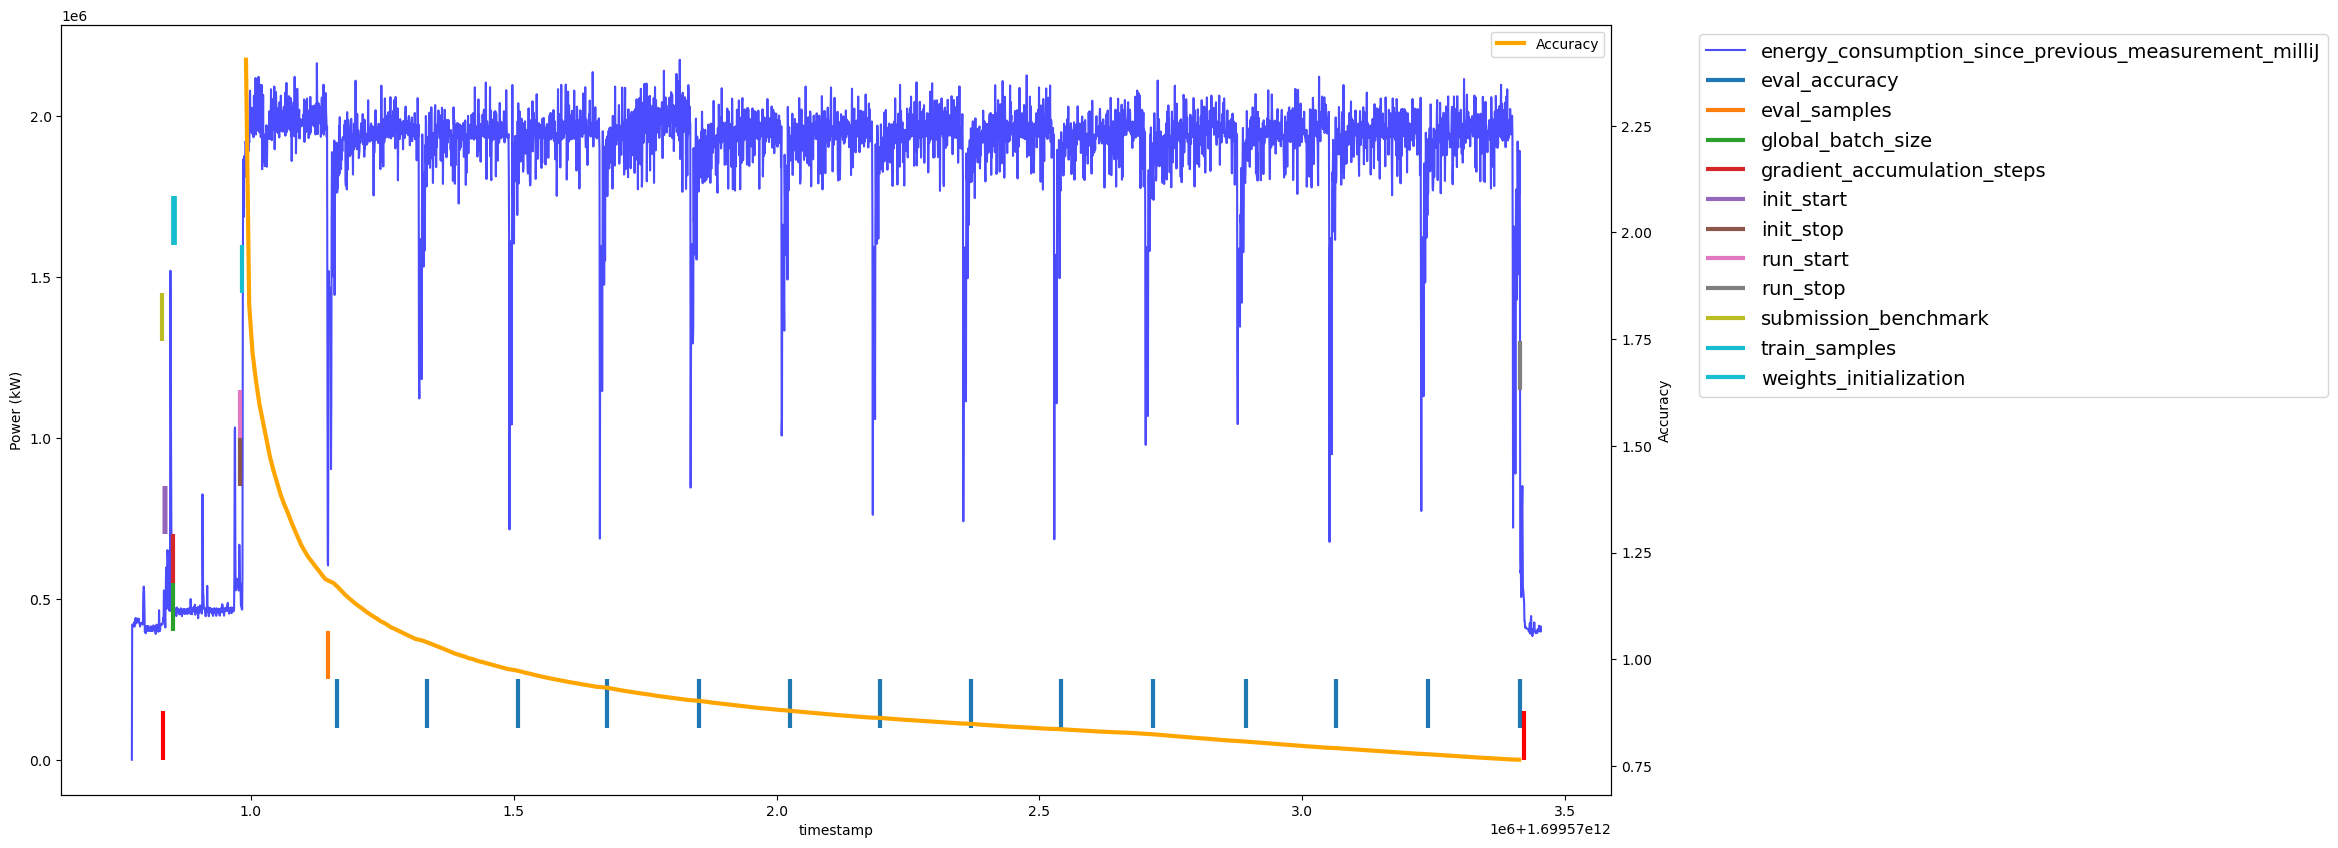

In [8]:
import itertools
import numpy as np
keys = ['eval_accuracy', 'eval_samples', 'global_batch_size',
       'gradient_accumulation_steps', 'init_start', 'init_stop',
       'run_start', 'run_stop', 
       'submission_benchmark', #'submission_division', 'submission_org', 'submission_platform','submission_status', 
       'train_samples', 'weights_initialization']

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()
energy[energy["job"]==job].sort_values(by="timestamp").groupby("timestamp")[["energy_consumption_since_previous_measurement_milliJ"]].sum().compute().plot(ax=ax,y="energy_consumption_since_previous_measurement_milliJ", color="blue", alpha=0.7)
ax.set_ylabel("Power (kW)")

COLOR = plt.cm.tab10
iter = itertools.cycle(COLOR(np.linspace(0, 1, len(keys))))
ymin = 1e5
size = 1.5e5
for key in keys:
    color = next(iter)
    ax.vlines(x=mllog[mllog["key"]==key]["timestamp"], ymin=ymin, ymax=ymin+size, color=color, linewidth=3, label=key)
    ymin+=size
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)

ax.vlines(x=jobs[jobs["job"]==job]["start_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")
ax.vlines(x=jobs[jobs["job"]==job]["end_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")

mllog[mllog["key"]=="tracked_stats"][["timestamp", "value.loss"]].plot(ax=ax2,x="timestamp", y="value.loss", label="Accuracy", color="orange", linewidth=3)
ax2.set_ylabel("Accuracy")


# For all jobs

In [9]:
def compute_energy_between_accuracies(row):
        """Compute energy between two accuracy values."""
        mask = (energy["timestamp"]>=row["timestamp"]-row["time_diff"])&(energy["timestamp"]<=row["timestamp"])
        energy_between_accuracies = energy[mask]["energy_kWh"].sum().compute()
        return energy_between_accuracies

accuracy_df = pd.DataFrame()

for job in jobs["job"].unique()[-10:]:
    file = jobs[jobs["job"]==job]["file"].values[0]
    file.split("/")[-2:]    
    log_file = path + "/".join(file.split("/")[-2:])

    loglines, _ = parse_file(log_file, ruleset="2.1.0")
    mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
    mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

    acc_df = mllog[mllog["key"]=="tracked_stats"][["timestamp", "value.loss"]].reset_index(drop=True)
    acc_df["time_diff"] = acc_df["timestamp"].diff()
    acc_df["acc_diff"] = acc_df["value.loss"].diff()
    acc_df.rename(columns={"value.loss":"loss"}, inplace=True)
    acc_df.at[0, "acc_diff"] = acc_df.at[0, "loss"]
    first_timestamp = acc_df.at[0, "timestamp"]
    run_start = mllog[mllog["key"]=='run_start']["timestamp"].values[0]
    acc_df.at[0, "time_diff"] = first_timestamp - run_start
    acc_df["energy_kWh"] = acc_df.apply(compute_energy_between_accuracies, axis=1)
    acc_df["energy_kWh_cumsum"] = acc_df["energy_kWh"].cumsum()
    acc_df["job"] = job
    
    accuracy_df = pd.concat([accuracy_df, acc_df])


In [12]:
accuracy_job = accuracy_df.merge(jobs, on="job", how="left")

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

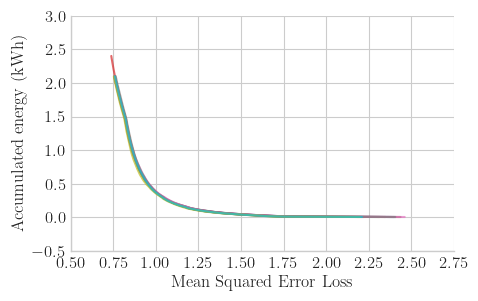

In [14]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="loss", y="energy_kWh_cumsum",
    data=accuracy_job[(accuracy_job["mllog_gradient_accumulation_steps"]==1)&(accuracy_job["node_nb"]==1)], 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set_xlabels("Mean Squared Error Loss", fontsize=FONTSIZE)
ax.set_ylabels("Accumulated energy (kWh)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/maskrcnn.pdf", dpi=300)